In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
# from IPython.display import display, HTML
# import bbknn
import time

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

### Load in the data

In [4]:
adata_xyz = sc.read_h5ad(prefix + 'box.data4/all_batches_mouse_only_processed.h5ad')

Adjust `var` names:

In [5]:
adata_xyz.var_names = [i[5:] for i in adata_xyz.var_names]
adata_xyz.var_names_make_unique()

In [6]:
new_raw = adata_xyz.raw.to_adata()
new_raw.var_names = [i[5:] for i in new_raw.var_names]
new_raw.var_names_make_unique()
adata_xyz.raw = new_raw

### Visualize

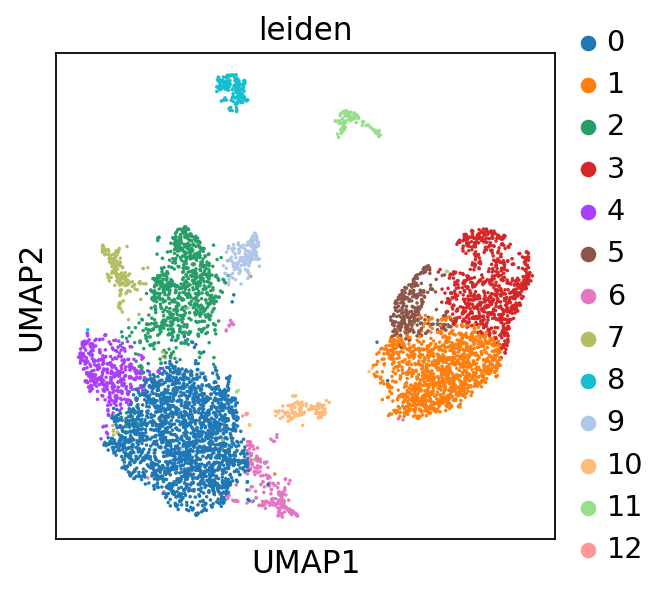

In [7]:
sc.pl.umap(adata_xyz,color=['leiden'], size=10, palette=sc.pl.palettes.default_20)

In [8]:
plate_map_path = prefix + 'box.data3/data/plate23_map.csv'

In [9]:
plate_map = pd.read_csv(plate_map_path, header=None, names=['barcode', 'X', 'Y'])

plate_map['Y'] = -plate_map['Y']

tmp = list()

for index, row in plate_map.iterrows():
    if row['X']%2==0:
        m=row['Y'] - .5
        tmp.append(m)
    else:
        tmp.append(row['Y'])
        
plate_map['Y_offset'] = pd.DataFrame(tmp)

plate_map = plate_map.drop(['Y'],axis=1)

plate_map.columns = ['barcode','X','Y']

In [10]:
adata_xyz.obs = adata_xyz.obs.reset_index().merge(plate_map, on='barcode',how='left').set_index('index')

In [11]:
adata_xyz0 = adata_xyz[adata_xyz.obs.batch == '0'].copy()
adata_xyz1 = adata_xyz[adata_xyz.obs.batch == '1'].copy()
adata_xyz2 = adata_xyz[adata_xyz.obs.batch == '2'].copy()
adata_xyz3 = adata_xyz[adata_xyz.obs.batch == '3'].copy()
adata_xyz4 = adata_xyz[adata_xyz.obs.batch == '4'].copy()

In [12]:
plt.rcParams['figure.figsize'] = [19, 9]
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30

## Figure S5D

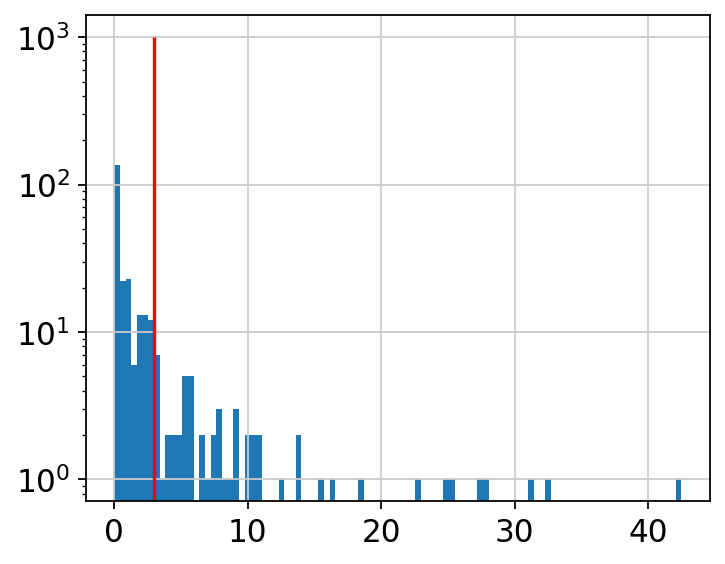

In [24]:
gene = 'Stat1'
adata_xyz1.obs[gene] = adata_xyz1.raw.obs_vector(gene)
vals = adata_xyz1.obs.groupby(['barcode','X','Y']).sum()[gene].reset_index()[gene].values
plt.figure(figsize=(5,4))
plt.hist(vals, bins=100);
plt.yscale('log')
plt.vlines(3, 0, 1e3, color='r');
adata_xyz1.obs.drop(columns=gene, inplace=True)

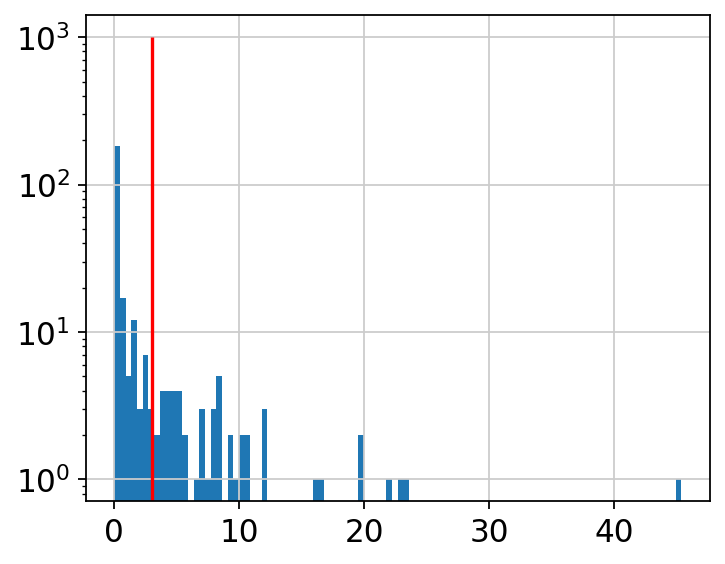

In [25]:
gene = 'Tgfbi'
adata_xyz1.obs[gene] = adata_xyz1.raw.obs_vector(gene)
vals = adata_xyz1.obs.groupby(['barcode','X','Y']).sum()[gene].reset_index()[gene].values
plt.figure(figsize=(5,4))
plt.hist(vals, bins=100);
plt.yscale('log')
plt.vlines(3, 0, 1e3, color='r');
adata_xyz1.obs.drop(columns=gene, inplace=True)

In [26]:
thresh = 3

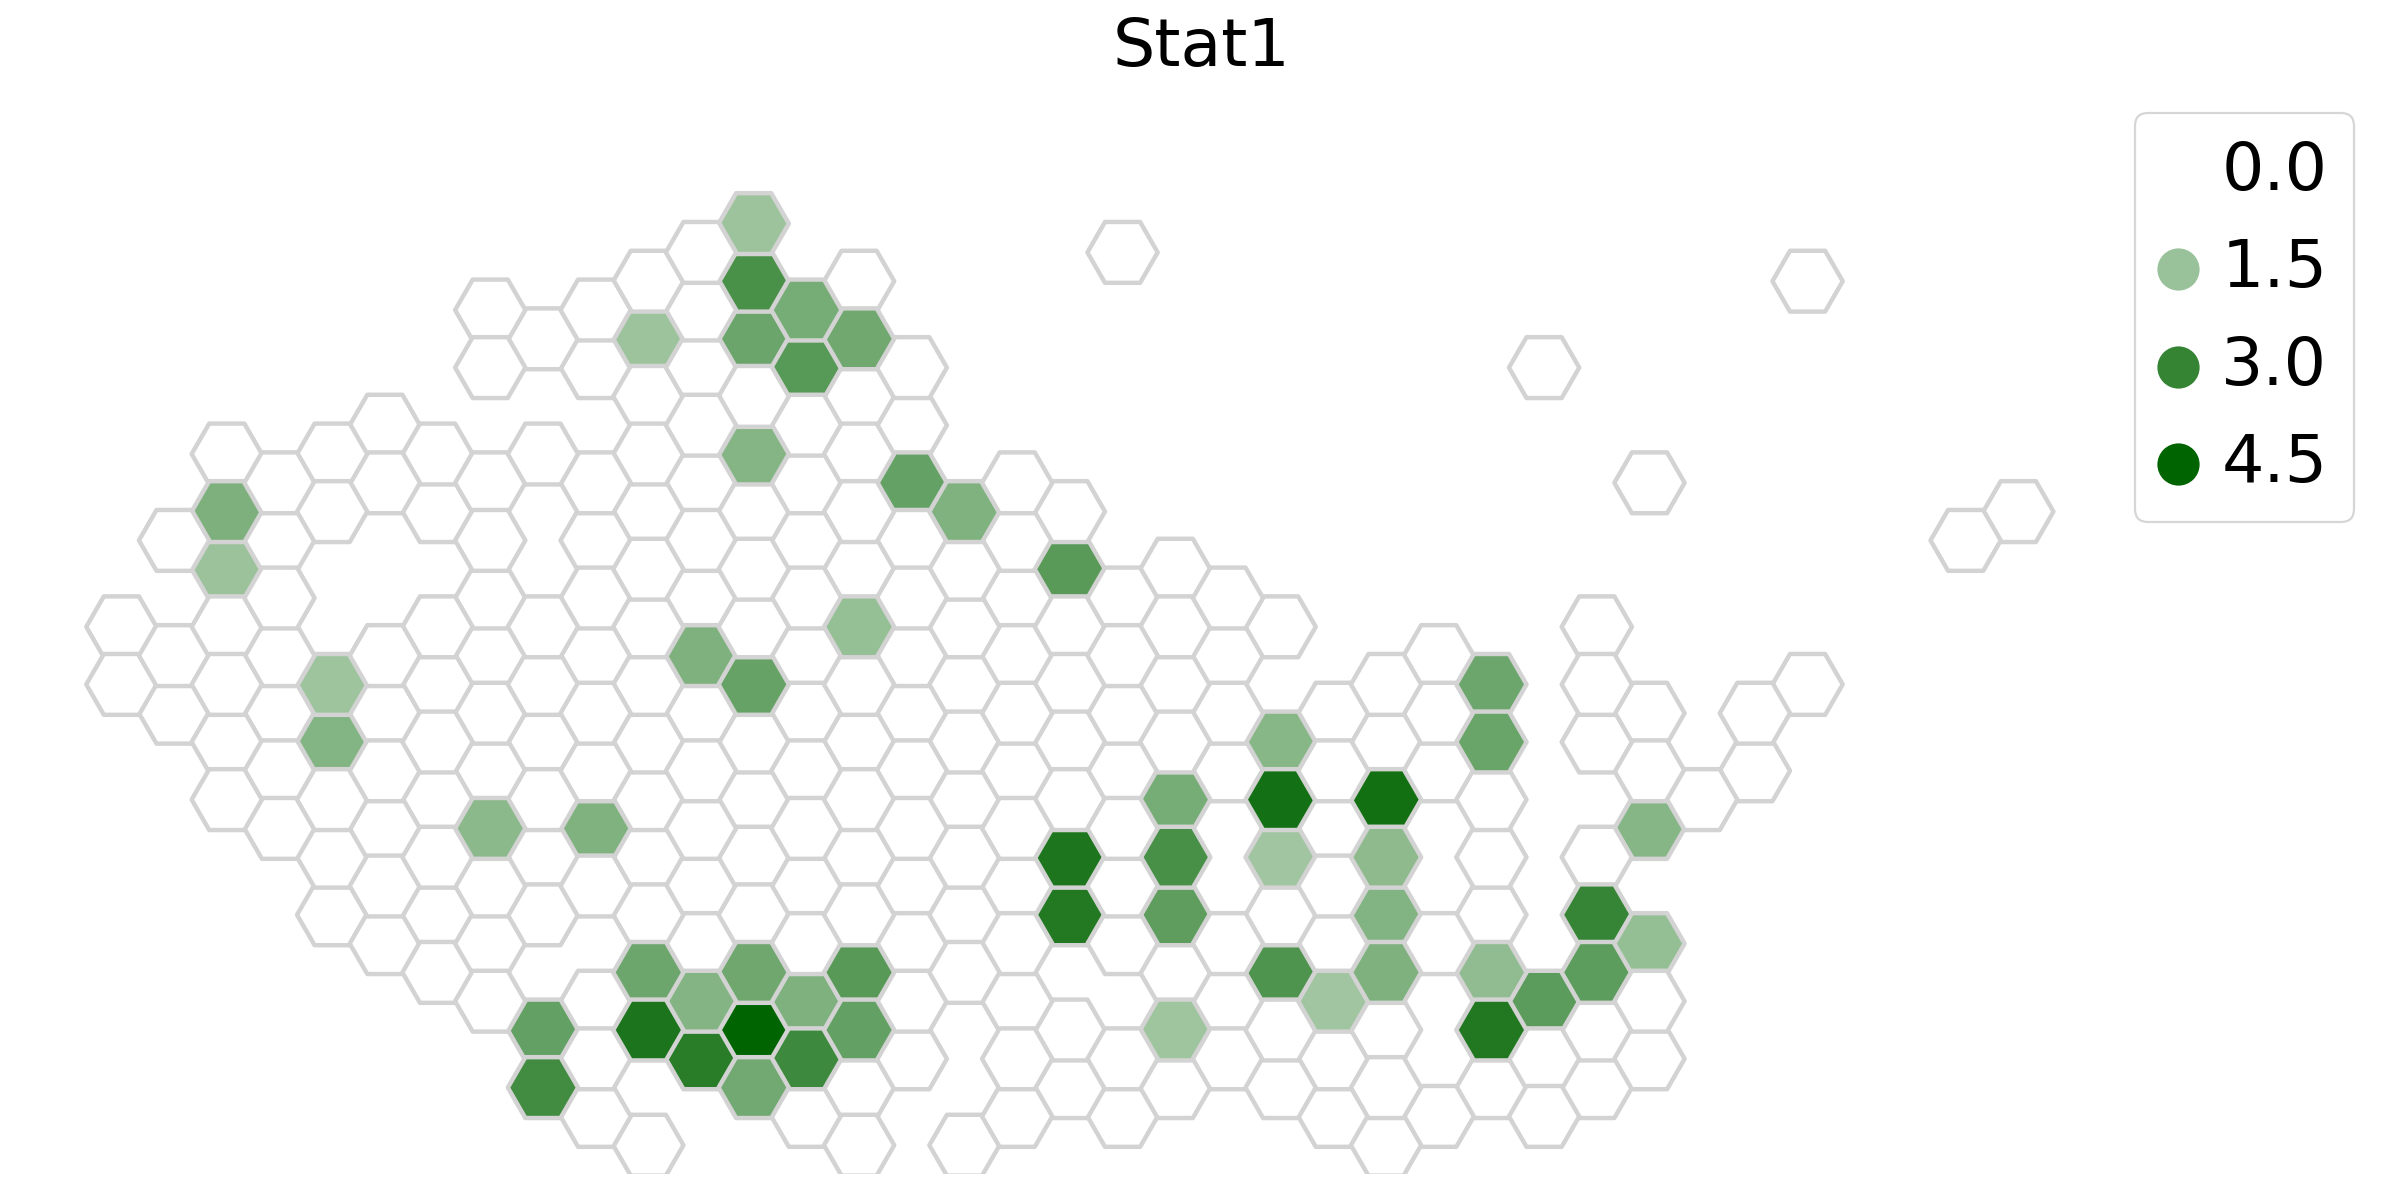

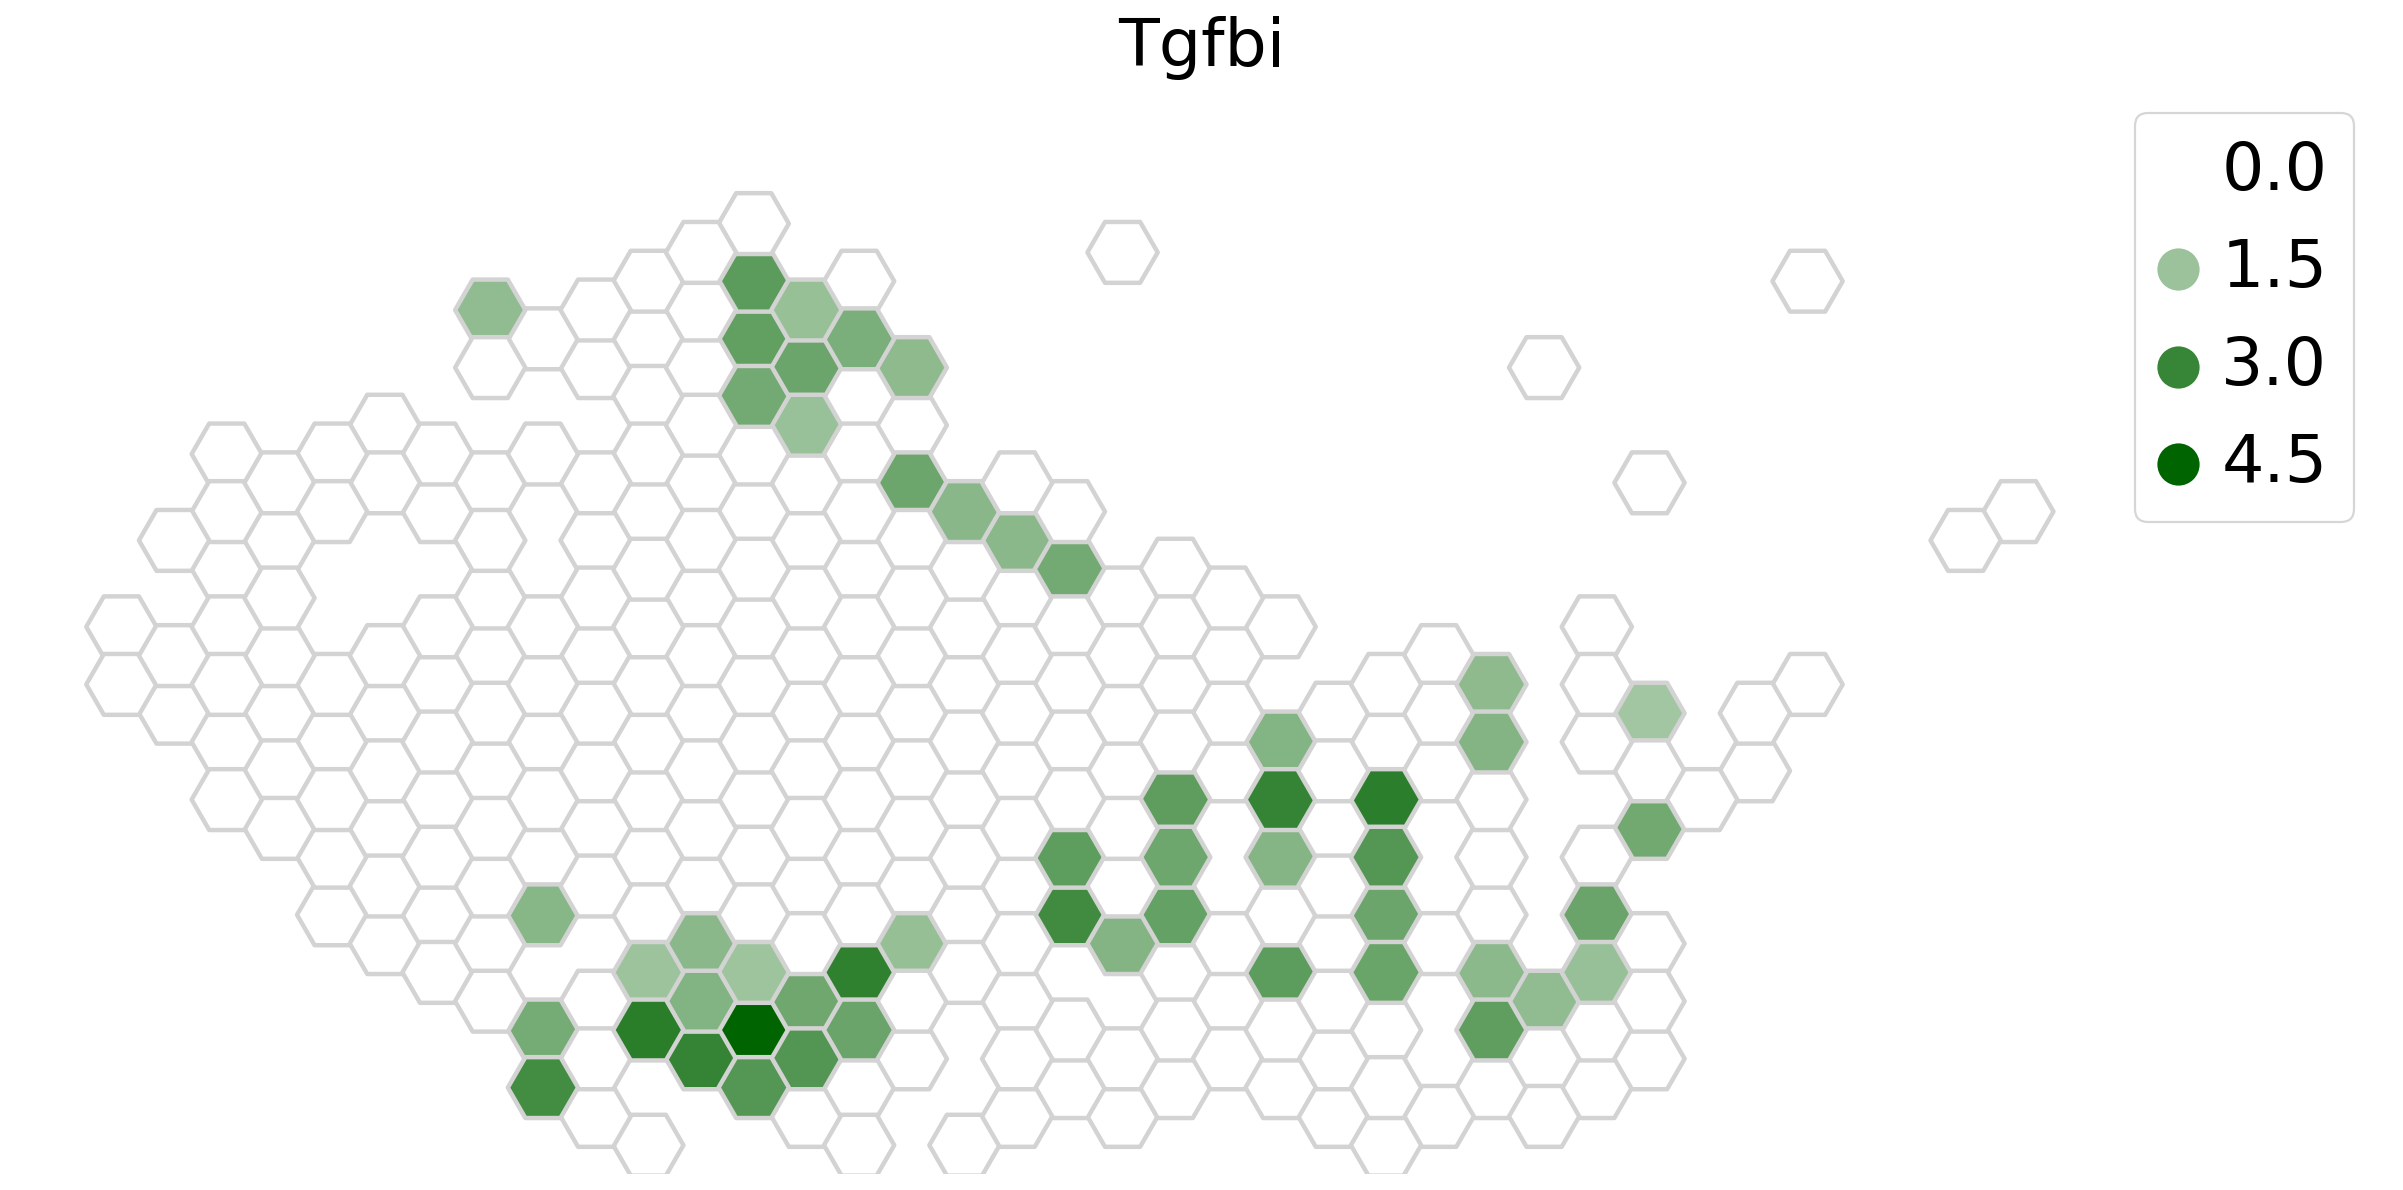

In [27]:
genes = ['Stat1', 'Tgfbi']

for gene in genes:

    plt.xlim(0, 45)
    plt.ylim(-19,0)
    
    adata_xyz1.obs[gene] = adata_xyz1.raw.obs_vector(gene)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(name="gene_plots",
                                                        colors=['white', 'darkgreen'])
    data_df = adata_xyz1.obs.groupby(['barcode','X','Y']).sum()[gene].reset_index()
    data_df[gene] = np.log1p(np.where(data_df[gene] < thresh, 0, data_df[gene]))
    g = sns.scatterplot(data=data_df,
                x='X',
                y='Y',
                marker="H",
                linewidth=2, edgecolor='lightgray',
                s=1000,
                hue=data_df[gene].tolist(),
                palette=cmap,
                legend='brief',
                        ###for solid colors:
                #c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]
                       )
    adata_xyz1.obs.drop(columns=gene, inplace=True)
    #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.grid(False)
    g.set_title(gene)
    g.xaxis.set_visible(False)
    g.yaxis.set_visible(False)
    for spine in g.spines:
        g.spines[spine].set_visible(False)        
#     plt.savefig("/data/xyzeq/figures/10X.down.XYZ.decontam/gh.for.youjin.01OCT20/S5D/plate.map.%s.svg" % gene)
    plt.show()

## Figures 3D and S4A

In [132]:
def get_colors(factor=0, lighter=True):
    plt.figure(figsize=(10,1))
    colors = np.array(plt.get_cmap('Set3').colors)
    if lighter:
        colors = colors + (1 - colors)*factor
    else:
        colors = c=colors*(1 - factor)
    colors = [mpl.colors.to_hex(i) for i in colors]
    plt.scatter(np.arange(12), [0]*12, c=colors, s=500)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.set_xticks(np.arange(12))
    plt.grid(False)
    return dict(zip(np.arange(12), colors))

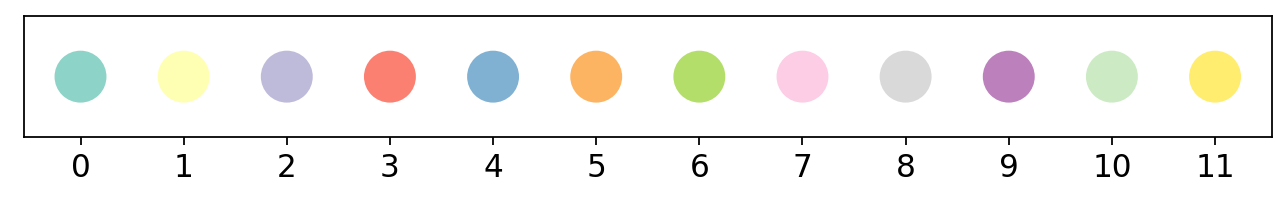

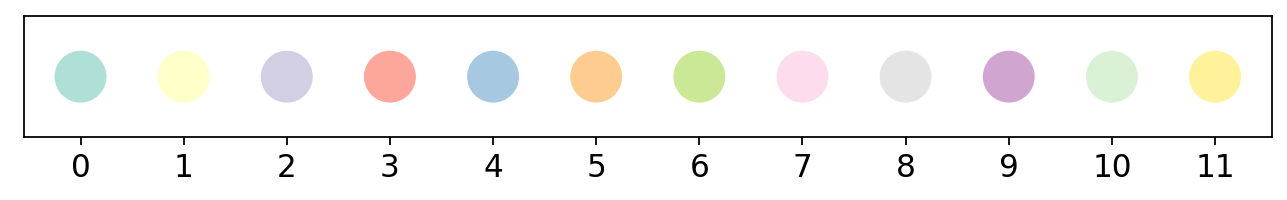

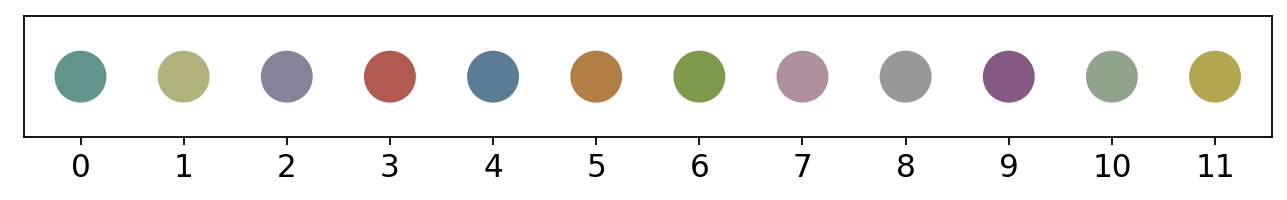

In [66]:
colors = get_colors()
light_colors = get_colors(factor=0.3, lighter=True)
dark_colors = get_colors(factor=0.3, lighter=False)

In [134]:
ctdict = dict()
ctdict['Myeloid'] = ['Macrophage', 'Monocyte']
# ctdict['XYZ_Monocyte'] = ['Monocyte']
ctdict['MC38'] = ['mc38']
ctdict['Kupffer'] = ['Kupffer']
ctdict['LSEC'] = ['LSEC']
ctdict['Lymphocyte'] = ['Lymphocyte']
ctdict['Hepatocyte'] = ['Hepatocyte']
ctdict['MSC'] = ['MSC']

for ct in ctdict:
    for clust in ctdict[ct]:
        adata_xyz1.obs['CellType'].replace(clust, ct, regex=True, inplace=True)
adata_xyz1.obs['CellType'] = adata_xyz1.obs['CellType'].astype('category')

In [135]:
paper_colormap = {
    'Hepatocyte': 3,
    'Kupffer': 5,
    'LSEC': 4,
    'Lymphocyte': 2,
    'MSC': 0,
    'Myeloid': 10,
    'MC38': 11,
}

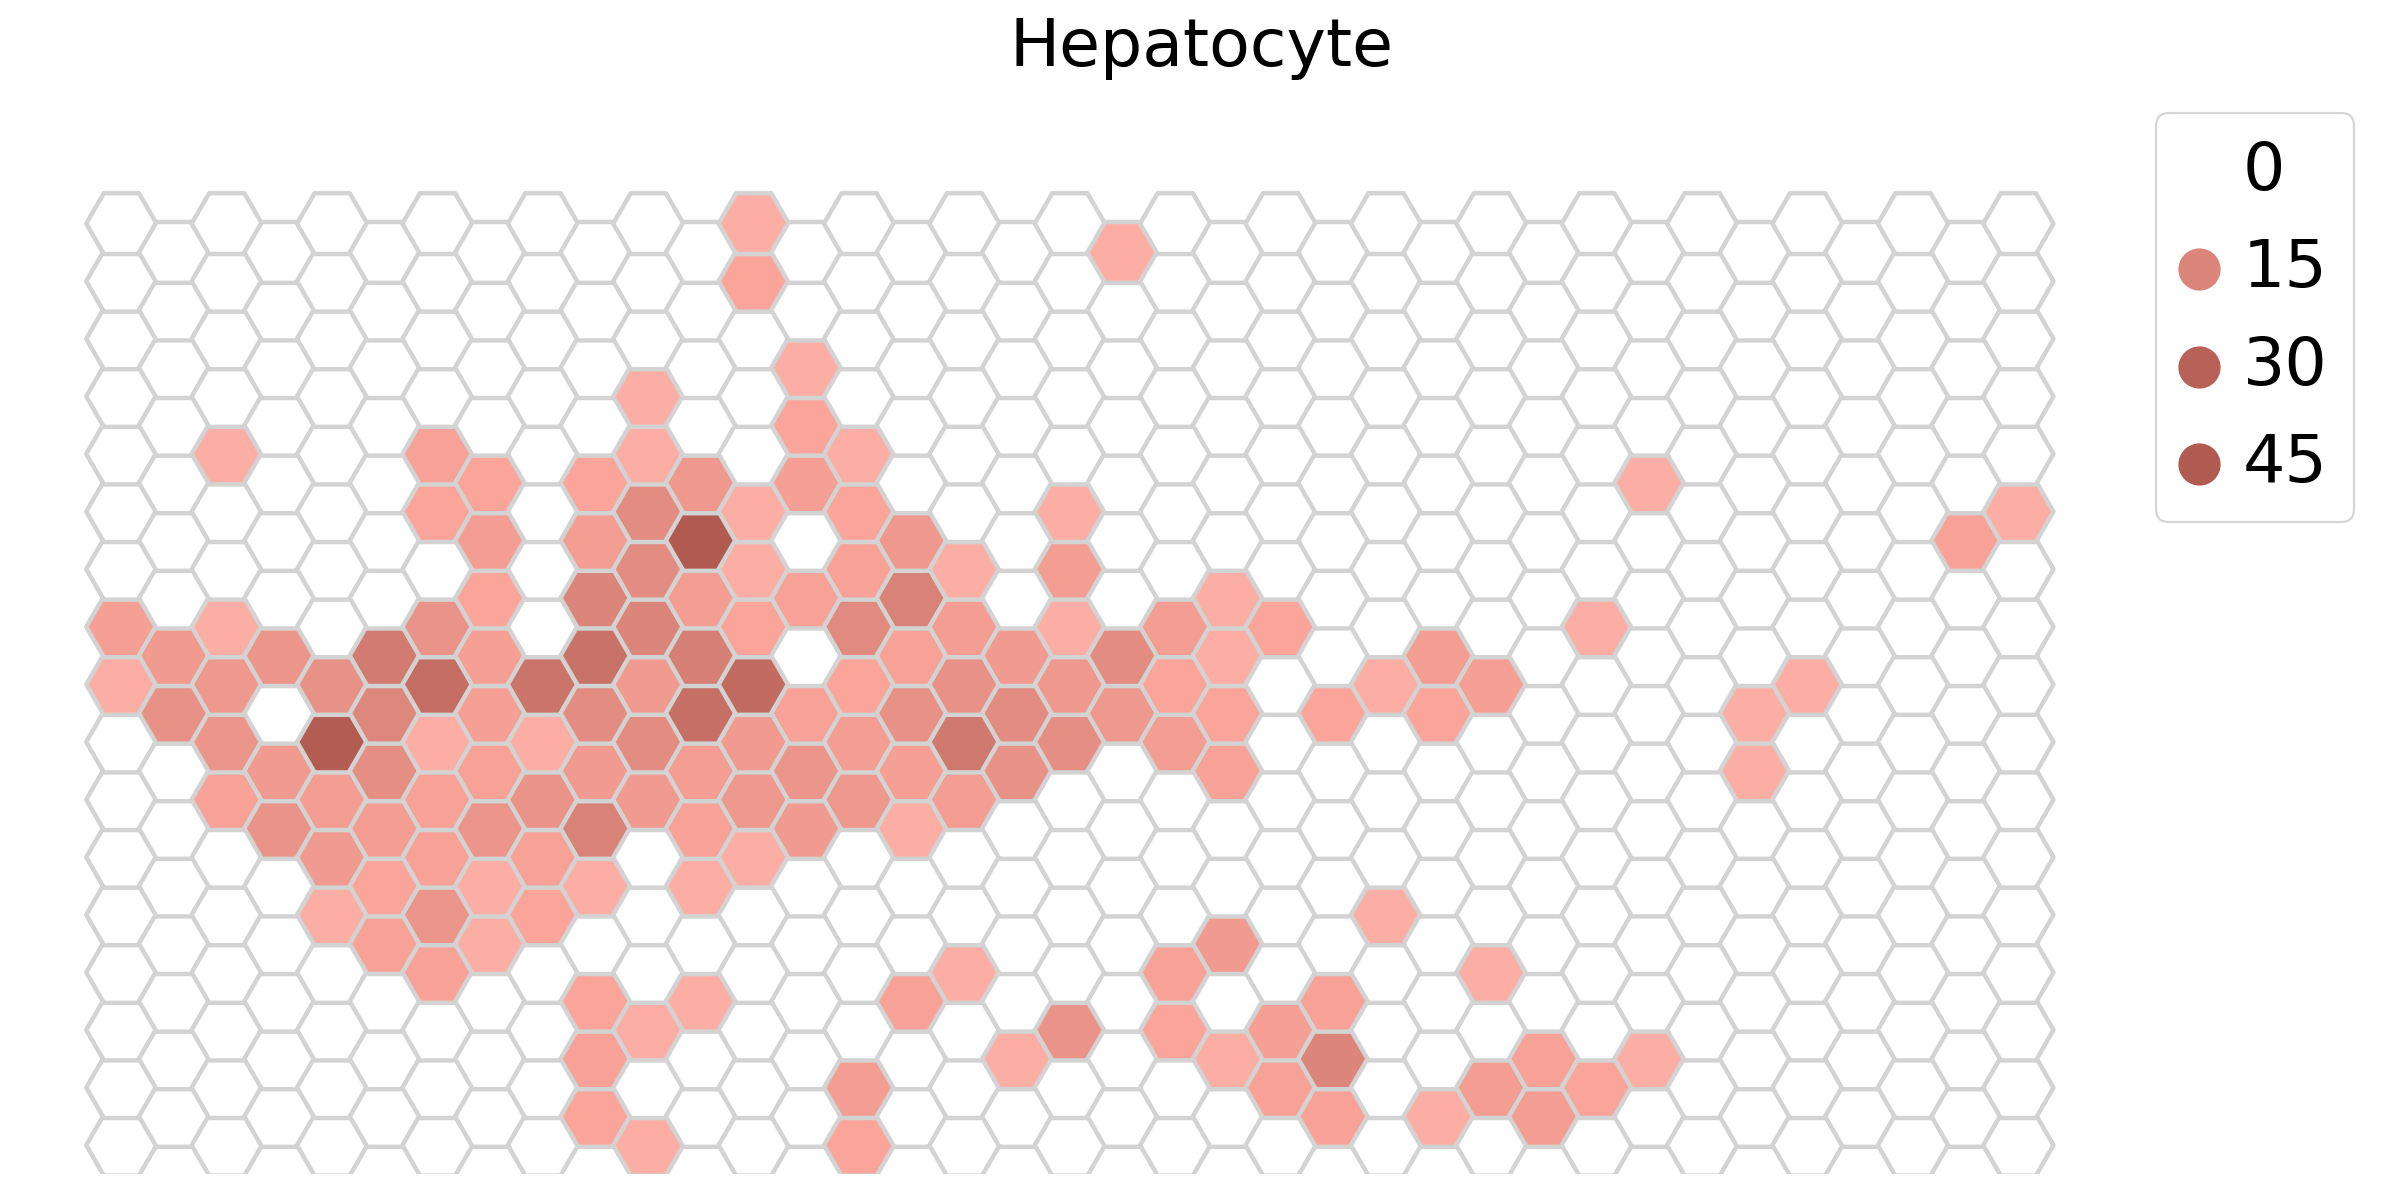

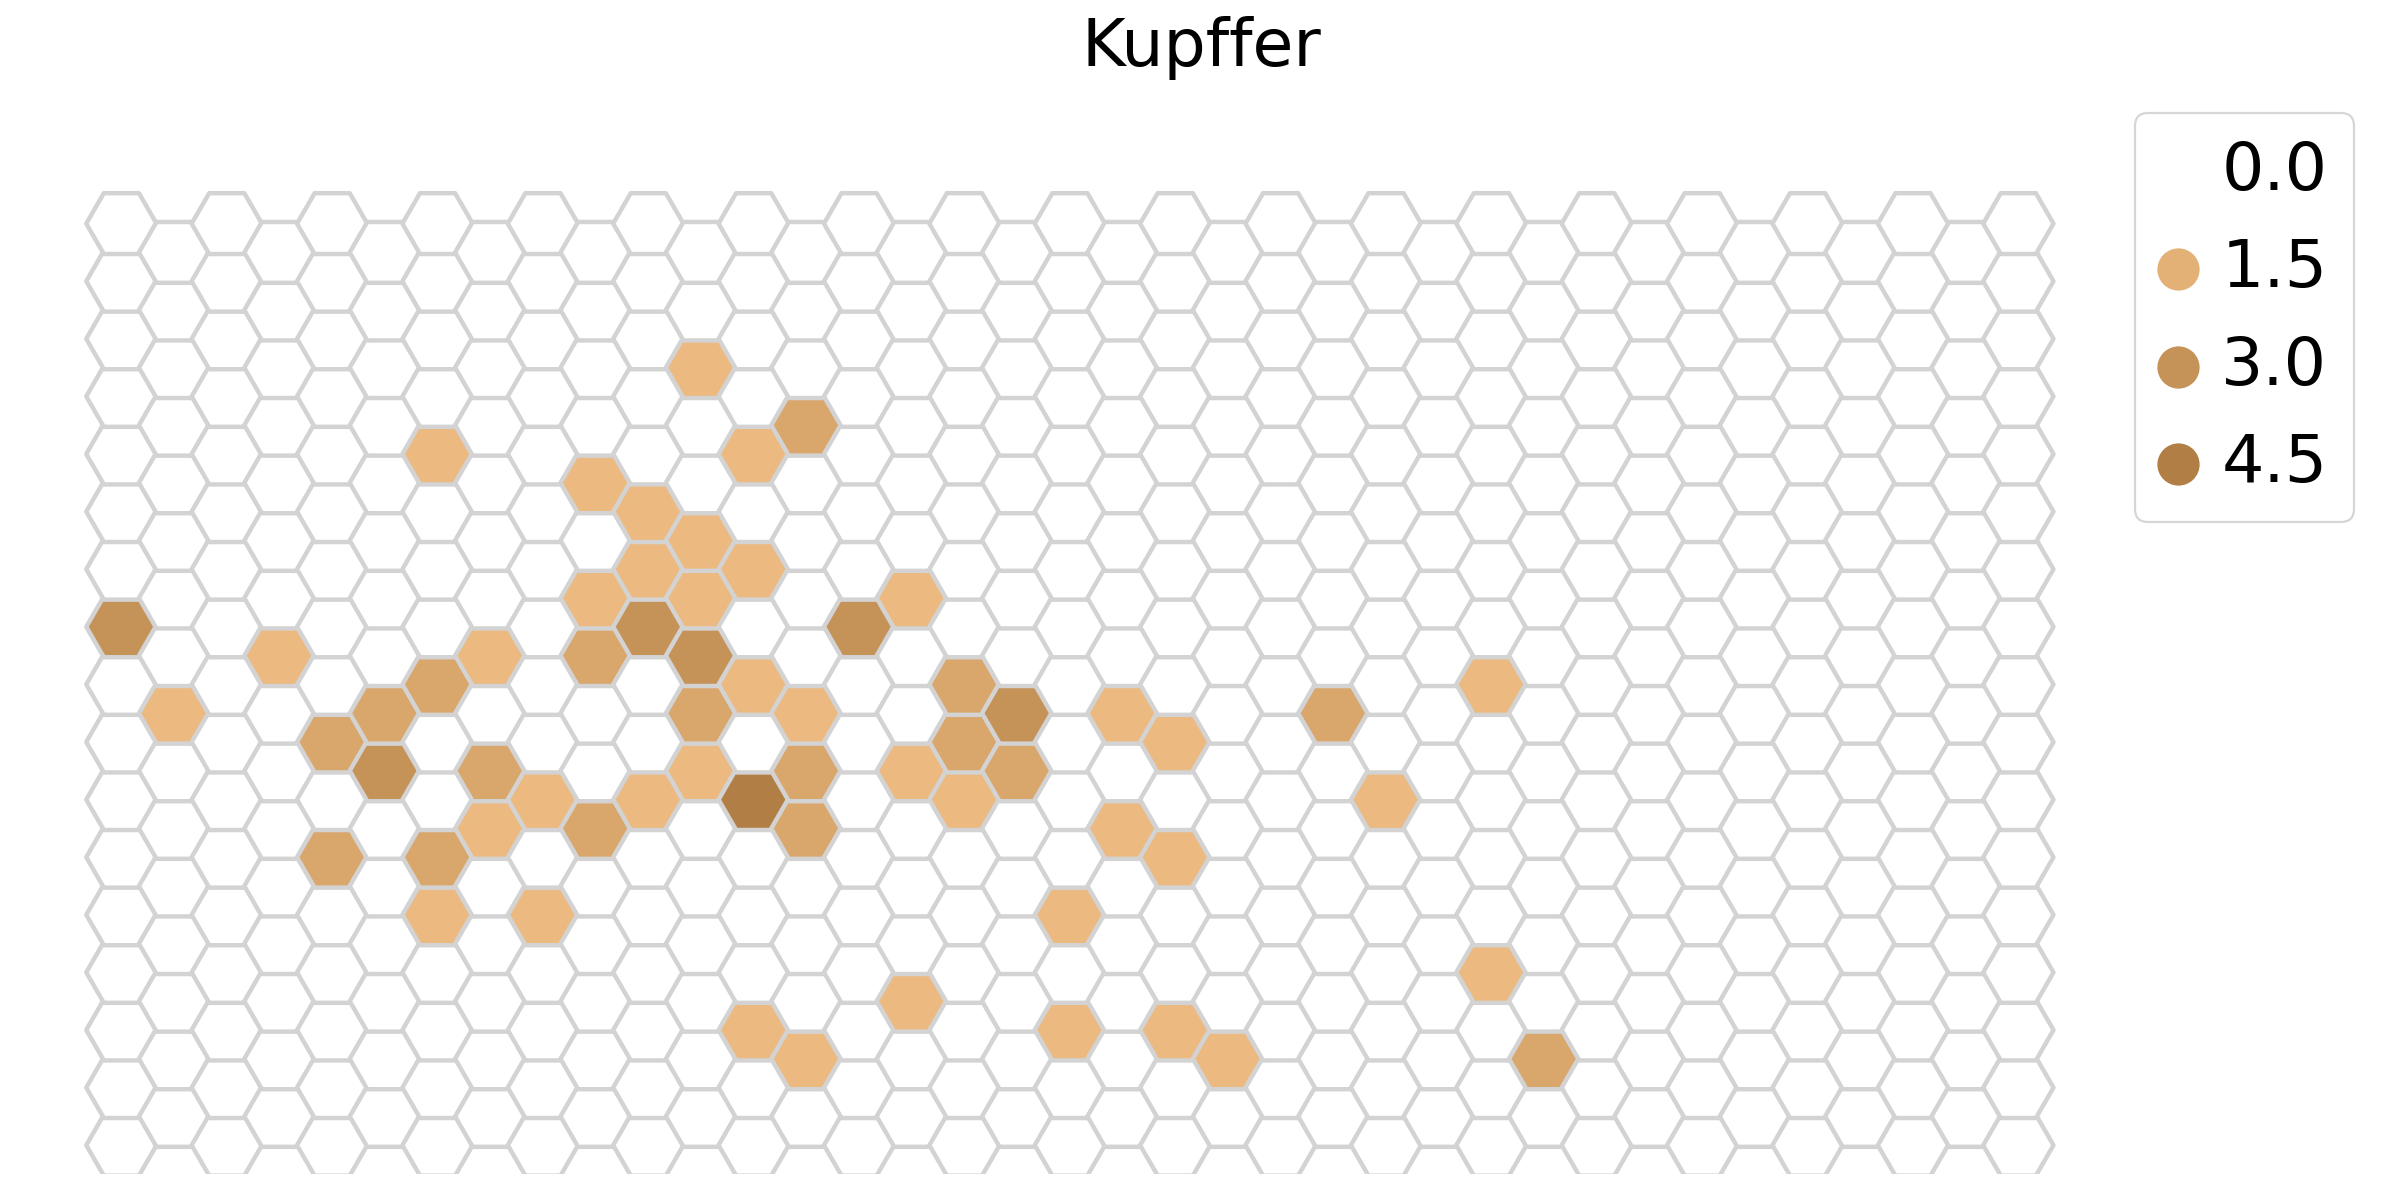

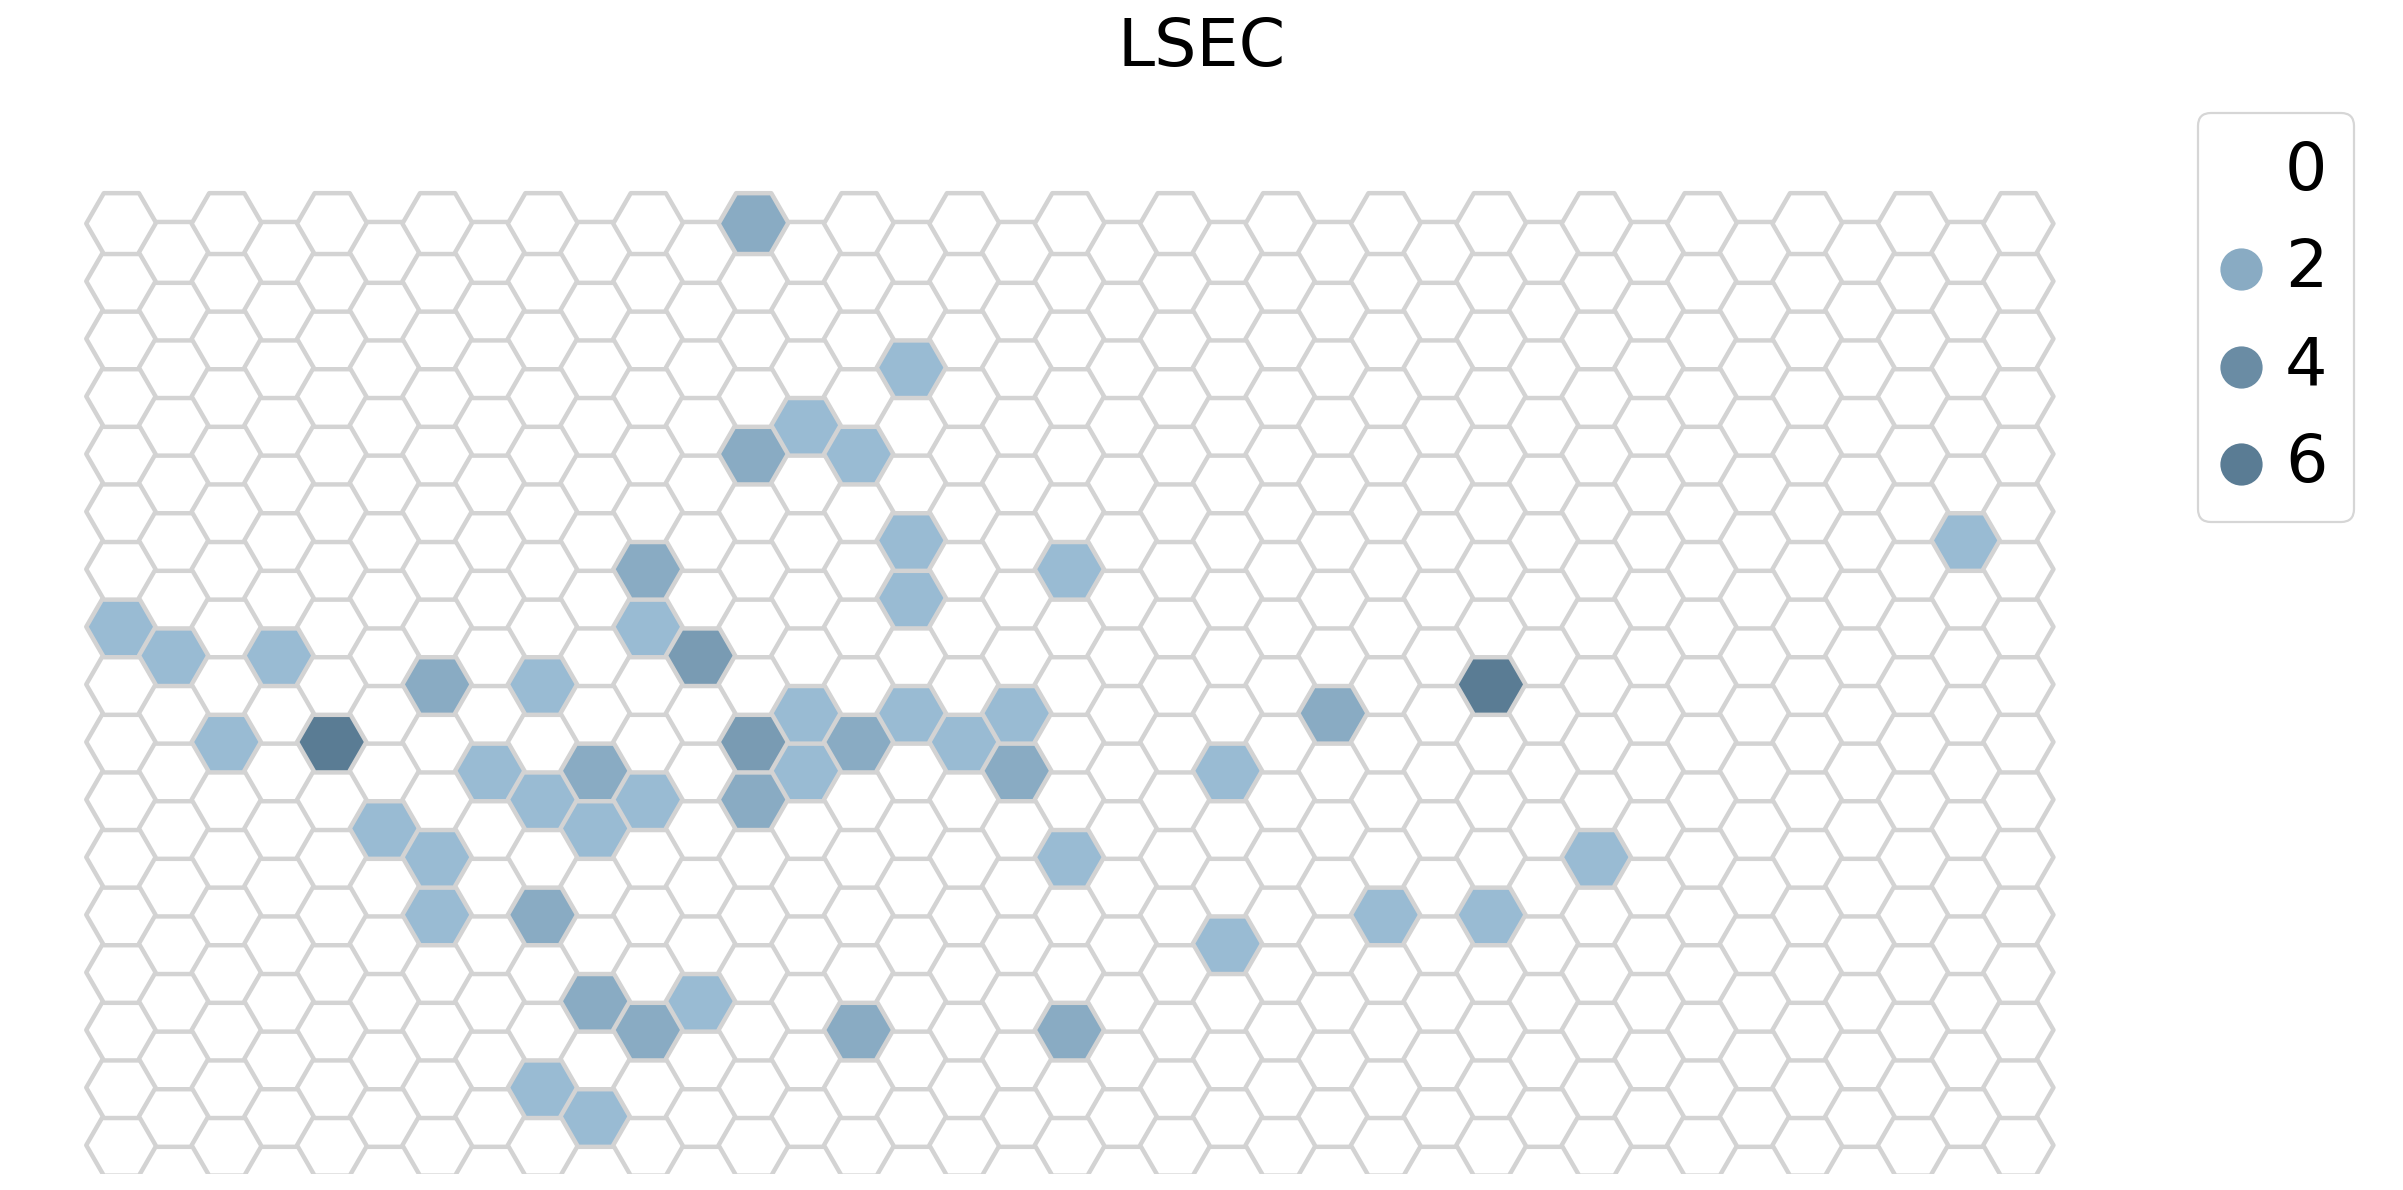

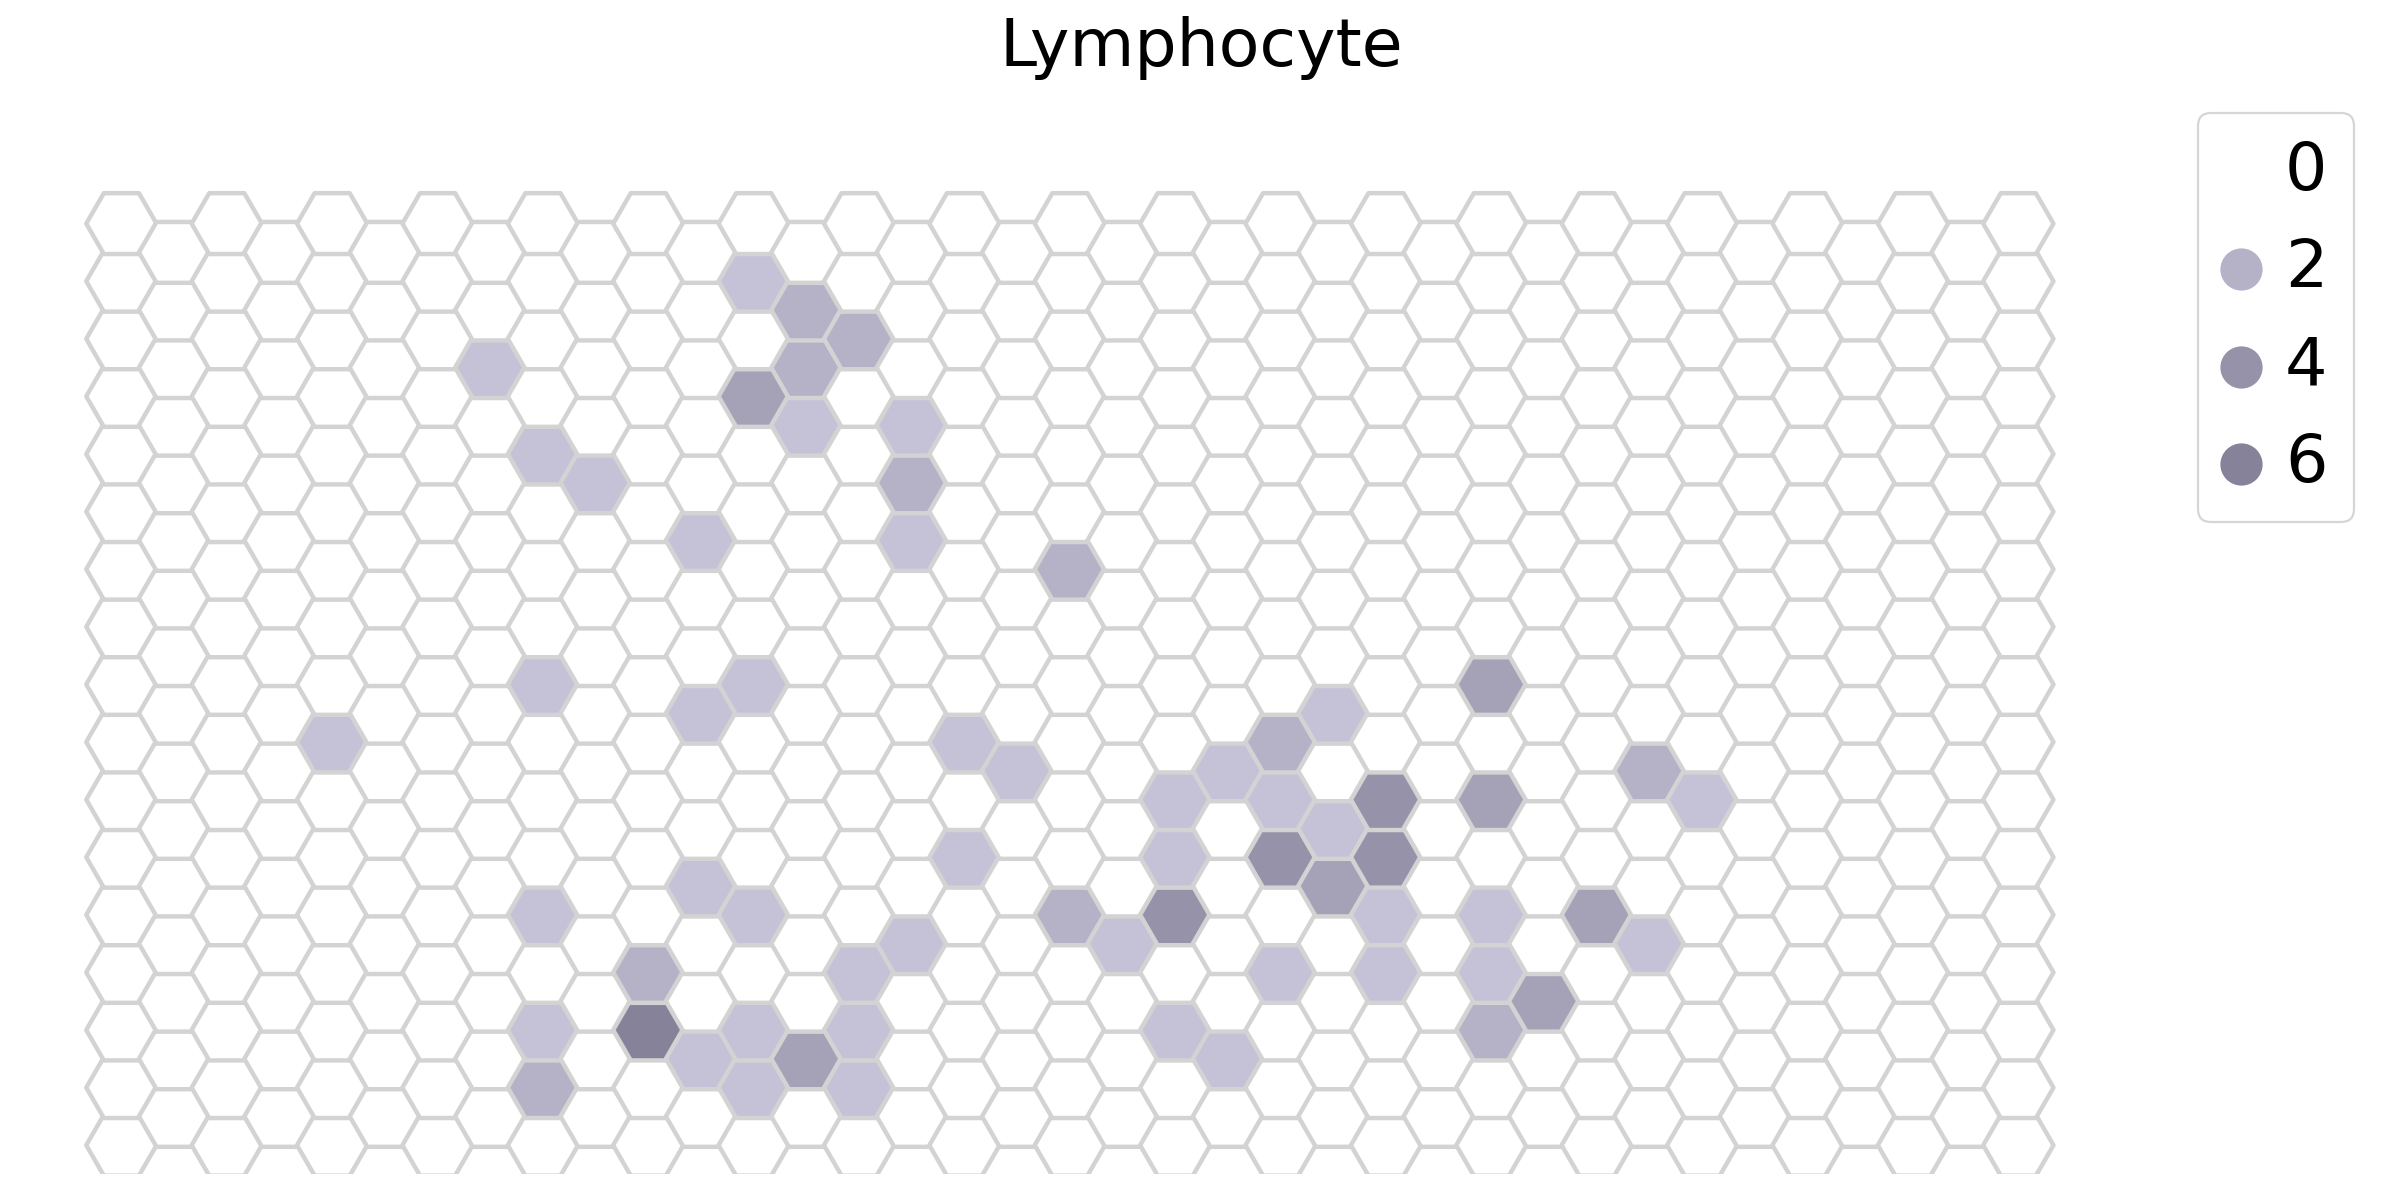

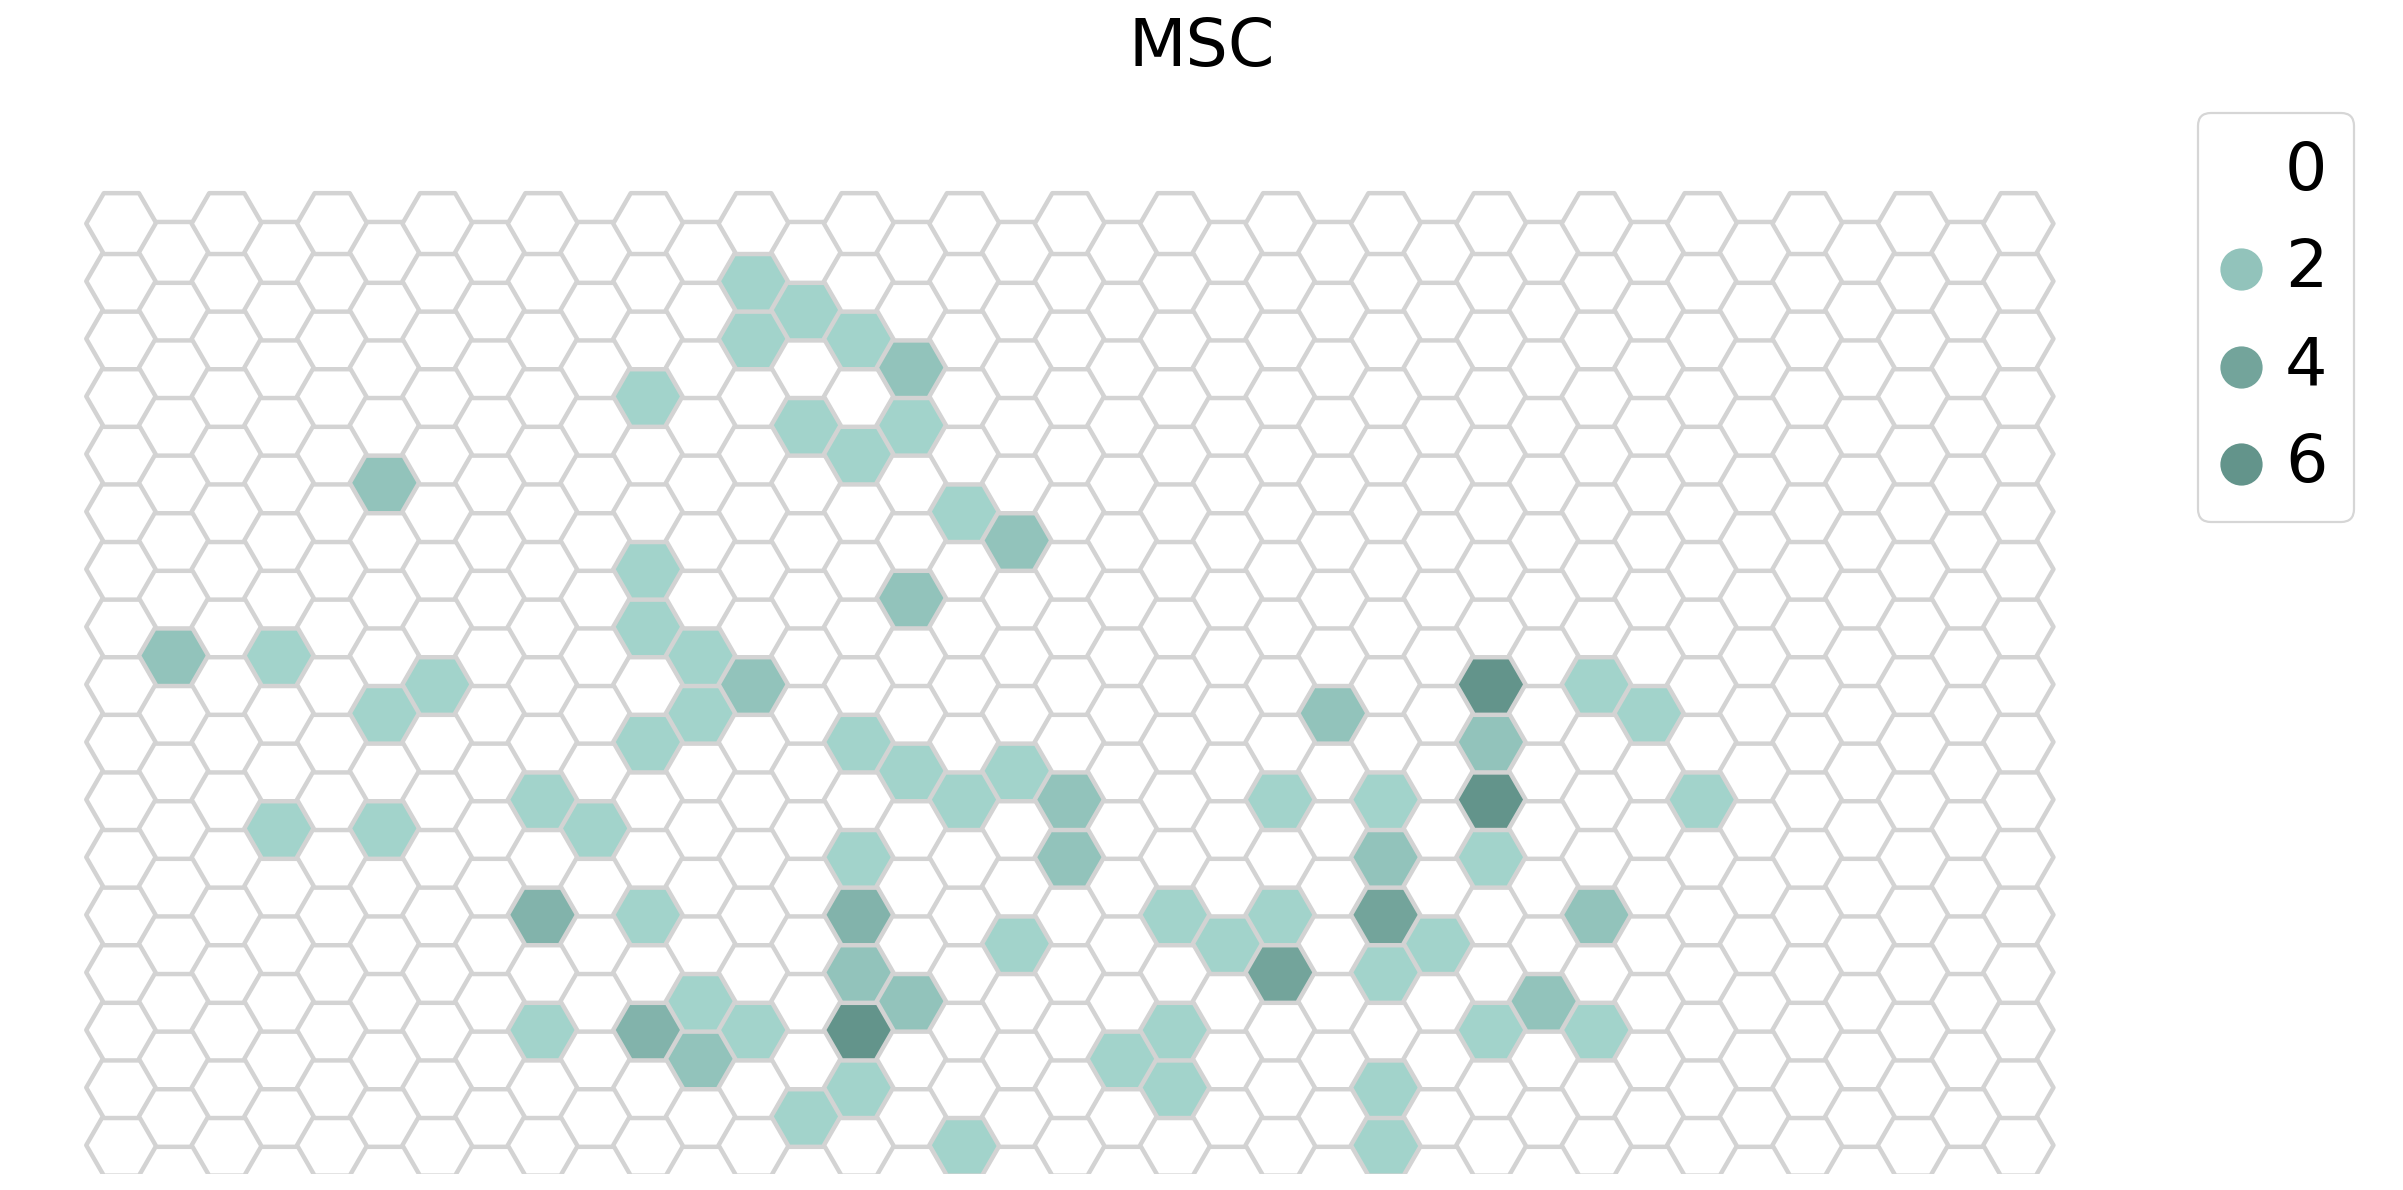

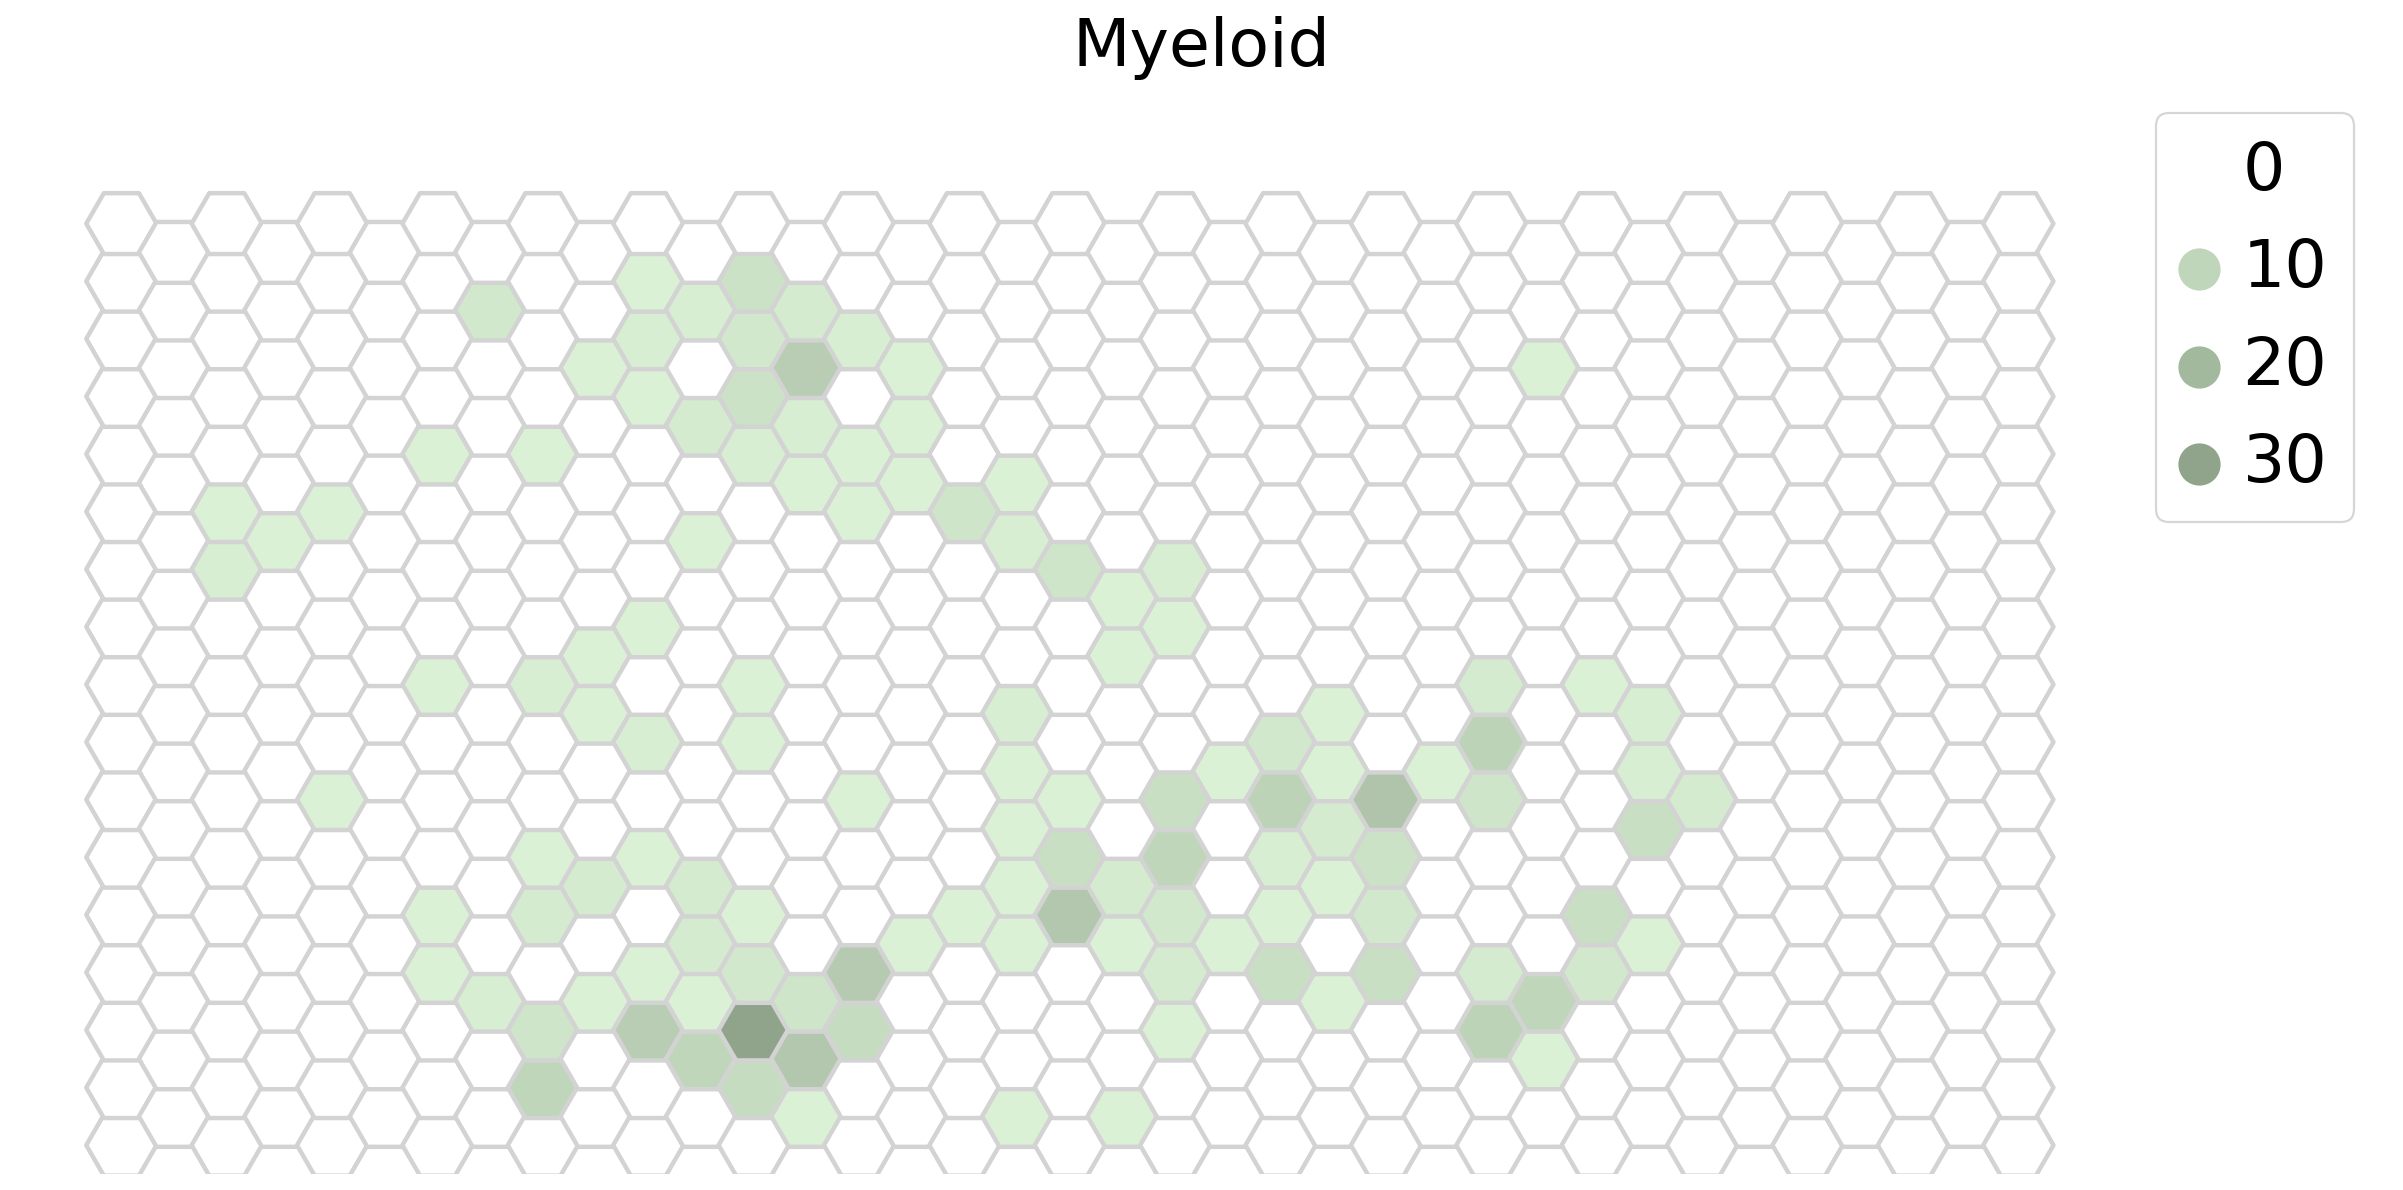

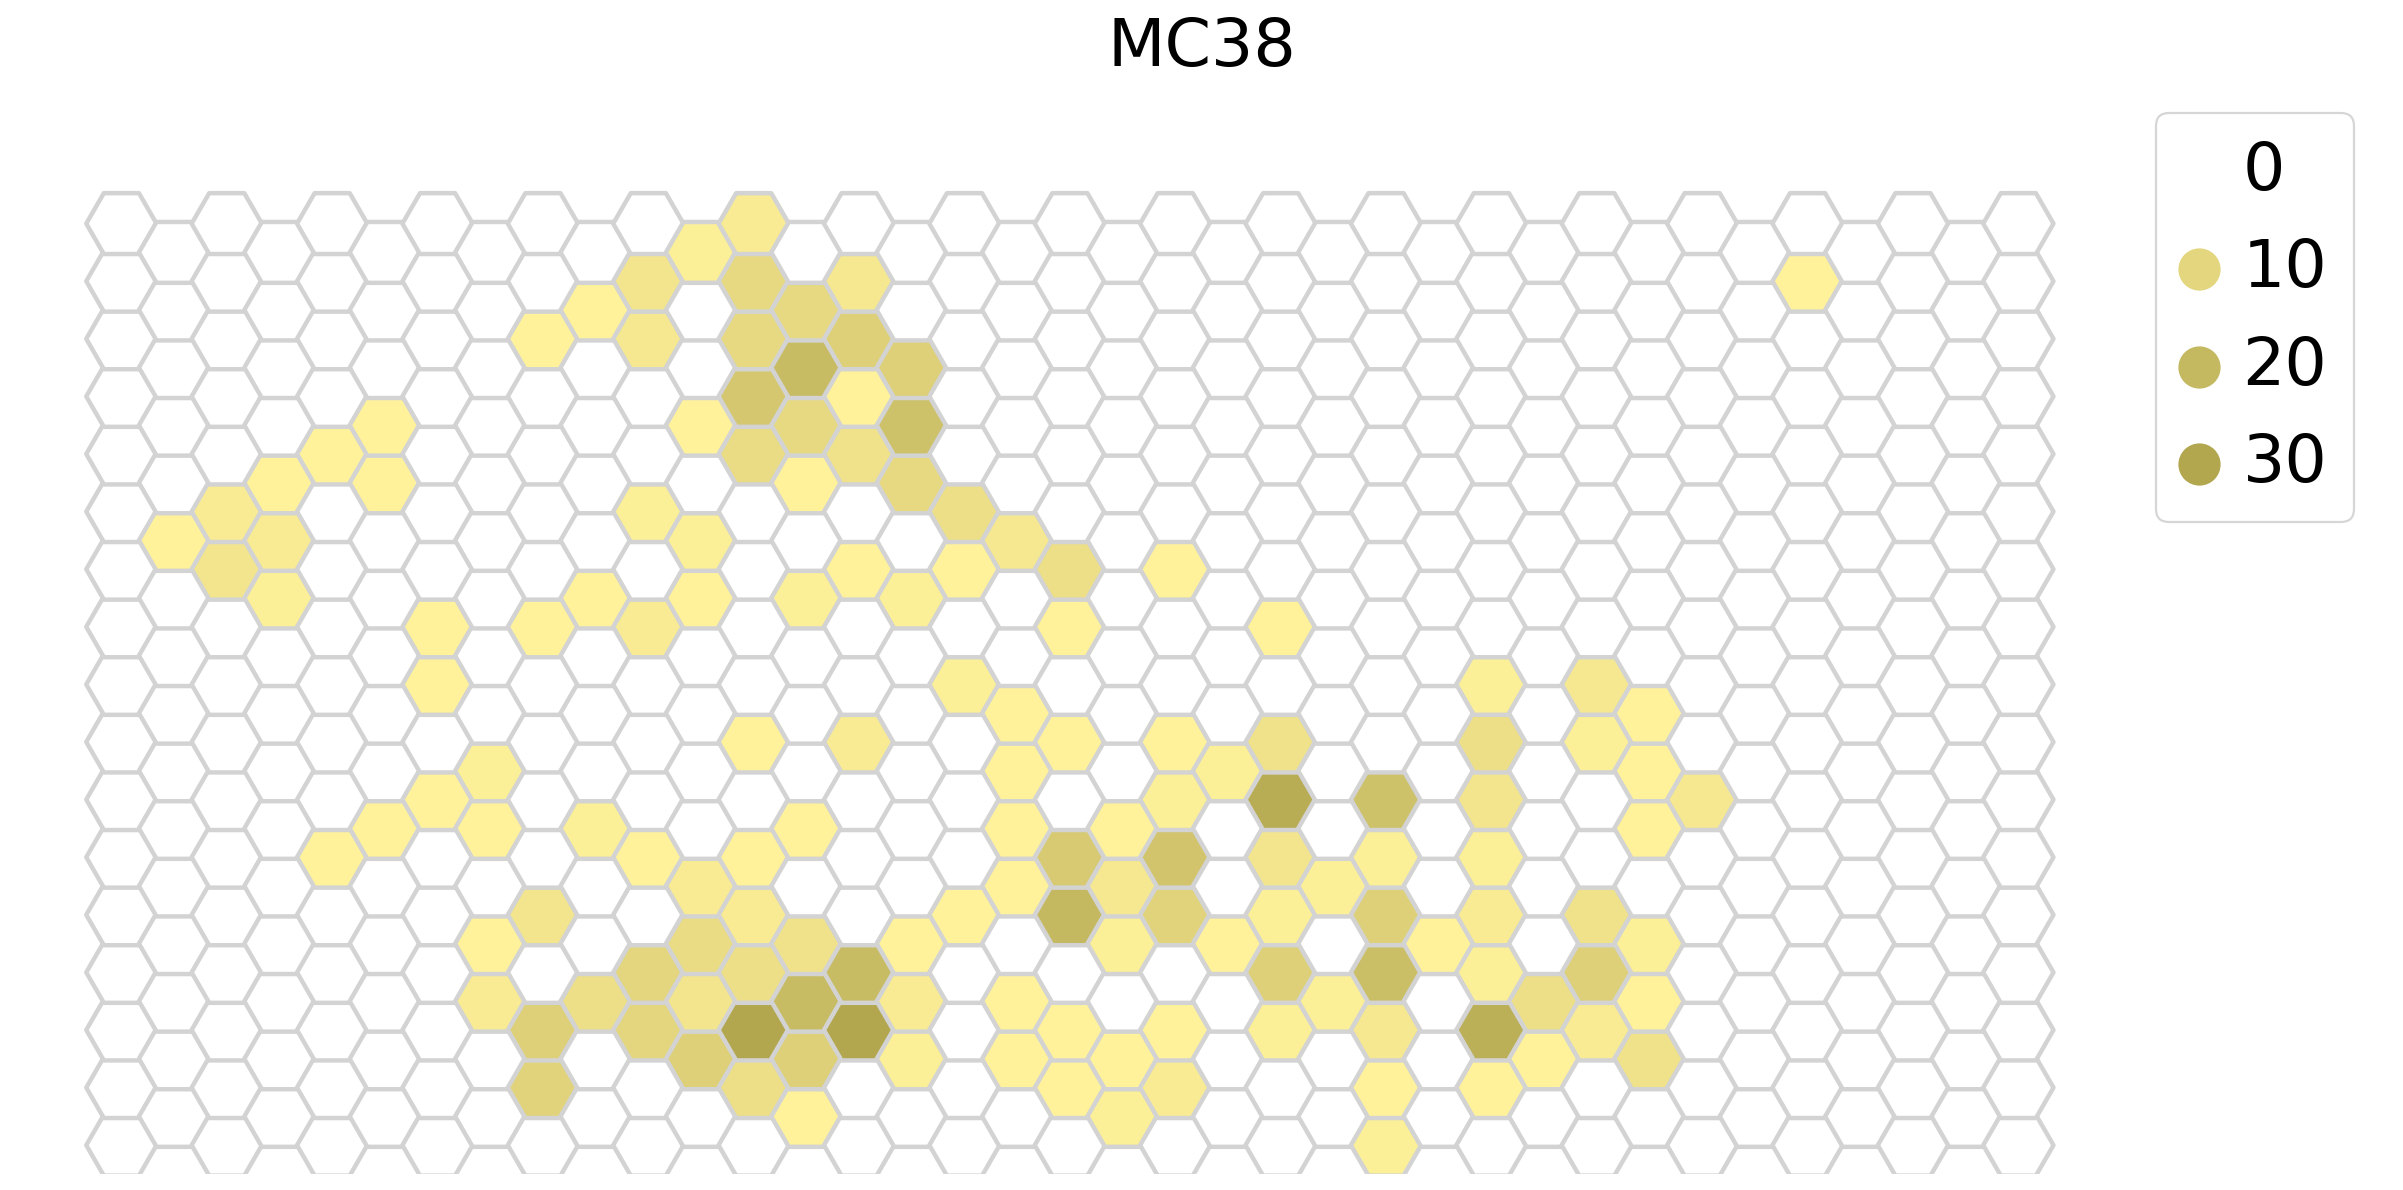

In [153]:
cts = adata_xyz1.obs['CellType'].dtype.categories
df = adata_xyz1.obs.groupby(['X', 'Y', 'CellType']).count().iloc[:,0].fillna(0).rename('count').reset_index()

# for some reason, the array is missing X columns 35 and 36
df = pd.concat([df, pd.DataFrame(it.product([35, 36], 
                                            df['Y'].value_counts().index.sort_values(), 
                                            df['CellType'].value_counts().index,
                                            [0]), 
                                 columns=['X', 'Y', 'CellType', 'count'])])

# wow this is annoying:
df = df[
    ~((df['X'] % 2 == 0) & (df['Y'] % 1 == 0)) &
    ~((df['X'] % 2 == 1) & (df['Y'] % 1 == 0.5))
]

for ct in cts:

    plt.xlim(0, 45)
    plt.ylim(-19,0)
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list(name="gene_plots",
                                                        colors=[(0, (1,1,1,0)),
                                                                (1/df['count'].max(), light_colors[paper_colormap[ct]]), 
                                                                (1, dark_colors[paper_colormap[ct]])])
    data_df = df[df['CellType'] == ct][['X', 'Y', 'count']]
#     data_df[gene] = np.log1p(np.where(data_df[gene] < thresh, 0, data_df[gene]))
    g = sns.scatterplot(data=data_df,
                x='X',
                y='Y',
                marker="H",
                linewidth=2, edgecolor='lightgray',
                s=1000,
                hue=data_df['count'].tolist(),
                palette=cmap,
                legend='brief',
                        ###for solid colors:
                #c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]
                       )
#     adata_xyz1.obs.drop(columns=gene, inplace=True)
    #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.grid(False)
    g.set_title(ct)
    g.xaxis.set_visible(False)
    g.yaxis.set_visible(False)
    for spine in g.spines:
        g.spines[spine].set_visible(False)        
#     plt.savefig("/data/xyzeq/figures/10X.down.XYZ.decontam/gh.for.youjin.12OCT20/3D_S4A/plate.map.%s.svg" % ct)
    plt.show()

In [147]:
df['Y'].value_counts().index.sort_values()

Float64Index([-18.5, -18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5,
              -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0,
               -9.5,  -9.0,  -8.5,  -8.0,  -7.5,  -7.0,  -6.5,  -6.0,  -5.5,
               -5.0,  -4.5,  -4.0,  -3.5,  -3.0,  -2.5],
             dtype='float64')

,X,Y,CellType,count
0,35,-18.5,MC38,0
1,35,-18.5,Myeloid,0
2,35,-18.5,MSC,0
3,35,-18.5,Lymphocyte,0
4,35,-18.5,LSEC,0
...,...,...,...,...
457,36,-2.5,MSC,0
458,36,-2.5,Lymphocyte,0
459,36,-2.5,LSEC,0
460,36,-2.5,Kupffer,0


,0,1,2,3
0,35,-18.5,MC38,0
1,35,-18.5,Myeloid,0
2,35,-18.5,MSC,0
3,35,-18.5,Lymphocyte,0
4,35,-18.5,LSEC,0
...,...,...,...,...
457,36,-2.5,MSC,0
458,36,-2.5,Lymphocyte,0
459,36,-2.5,LSEC,0
460,36,-2.5,Kupffer,0
